In [89]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator
from pyspark.sql.types import DecimalType, IntegerType, DateType, DoubleType
from pyspark.ml import Pipeline

In [19]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [71]:
df = spark.read.csv('./AirBnb_NYC_2019.csv',header='true',inferSchema='true')

In [72]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('room_type', 'string'),
 ('price', 'string'),
 ('minimum_nights', 'string'),
 ('number_of_reviews', 'string'),
 ('last_review', 'string'),
 ('reviews_per_month', 'string'),
 ('calculated_host_listings_count', 'string'),
 ('availability_365', 'int')]

In [73]:
from pyspark.sql.functions import when,col

In [74]:
df.select('price').describe().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             48894|
|   mean|152.22296299343384|
| stddev|238.54148640283205|
|    min|         -73.99986|
|    max|      Private room|
+-------+------------------+



In [75]:
df = df.withColumn("latitude",df["latitude"].cast(DecimalType()))
df = df.withColumn("longitude",df["longitude"].cast(DecimalType()))
df = df.withColumn("price",df["price"].cast(IntegerType()))
df = df.withColumn("minimum_nights",df["minimum_nights"].cast(IntegerType()))
df = df.withColumn("number_of_reviews",df["number_of_reviews"].cast(IntegerType()))
df = df.withColumn("calculated_host_listings_count",df["calculated_host_listings_count"].cast(IntegerType()))
df = df.withColumn("last_review",df["last_review"].cast(DateType()))
df = df.withColumn("reviews_per_month",df["reviews_per_month"].cast(DoubleType()))
df = df.withColumn("availability_365",df["availability_365"].cast(IntegerType()))

df = df.withColumn("price", when(col("price")>1000,1000).otherwise(col("price")))
df = df.filter(df['price']>=0)
df = df.withColumn("minimum_nights", when(col("minimum_nights")>30,30).otherwise(col("minimum_nights")))
df = df.withColumn('calculated_host_listings_count', when(col('calculated_host_listings_count')>10,
                                                           10).otherwise(col('calculated_host_listings_count')))
df = df.withColumn("reviews_per_month",when(col('reviews_per_month')>10,10).otherwise(col('reviews_per_month')))
df = df.withColumn('number_of_reviews', when(col('number_of_reviews')>100,100).otherwise(col('number_of_reviews')))

In [76]:
df.select('reviews_per_month').describe().show()

+-------+-----------------+
|summary|reviews_per_month|
+-------+-----------------+
|  count|            38856|
|   mean|1.366932520074134|
| stddev|1.620253047489511|
|    min|             0.01|
|    max|             10.0|
+-------+-----------------+



In [77]:
#creates indexes for each string
indexers = [StringIndexer(inputCol=col, 
                          outputCol=col+'_index',
                         handleInvalid='keep').fit(df) for col in ['neighbourhood_group',
                                                                      'neighbourhood',
                                                                      'room_type']]
pipe = Pipeline(stages=indexers)
df = pipe.fit(df).transform(df)

#creates columns with 0 or 1 for each index
encoder = OneHotEncoderEstimator(inputCols=['neighbourhood_group_index','neighbourhood_index',
                                             'room_type_index'],
                                 outputCols=['neighbourhood_group_dummy','neighbourhood_dummy',
                                             'room_type_dummy'],
                                dropLast=True)
df = encoder.fit(df).transform(df)

df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'decimal(10,0)'),
 ('longitude', 'decimal(10,0)'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'double'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('neighbourhood_group_index', 'double'),
 ('neighbourhood_index', 'double'),
 ('room_type_index', 'double'),
 ('neighbourhood_group_dummy', 'vector'),
 ('neighbourhood_dummy', 'vector'),
 ('room_type_dummy', 'vector')]

In [78]:
df = df.na.drop()

In [79]:
target = 'price'
features = df.drop('id',
                     'name',
                     'host_id',
                     'host_name',
                     'neighbourhood_group_index',
                     'neighbourhood_index',
                     'room_type_index',
                     'neighbourhood_group',
                     'neighbourhood',
                     'room_type',
                  'price',
                  'last_review').columns

vector = VectorAssembler(inputCols= features,
                         outputCol='features')

vectorized_df = vector.transform(df)
vectorized_df = vectorized_df.select(['features','price'])
vectorized_df.show()

+--------------------+-----+
|            features|price|
+--------------------+-----+
|(529,[0,1,2,3,4,5...|  149|
|(529,[0,1,2,3,4,5...|  225|
|(529,[0,1,2,3,4,5...|   89|
|(529,[0,1,2,3,4,5...|   80|
|(529,[0,1,2,3,4,5...|  200|
|(529,[0,1,2,3,4,5...|   60|
|(529,[0,1,2,3,4,5...|   79|
|(529,[0,1,2,3,4,5...|   79|
|(529,[0,1,2,3,4,5...|  150|
|(529,[0,1,2,3,4,5...|  135|
|(529,[0,1,2,3,4,5...|   85|
|(529,[0,1,2,3,4,5...|   89|
|(529,[0,1,2,3,4,5...|   85|
|(529,[0,1,2,3,4,5...|  120|
|(529,[0,1,2,3,4,5...|  140|
|(529,[0,1,2,3,4,5...|  215|
|(529,[0,1,2,3,4,5...|  140|
|(529,[0,1,2,3,4,5...|   99|
|(529,[0,1,2,3,4,5...|  299|
|(529,[0,1,2,3,4,5...|  130|
+--------------------+-----+
only showing top 20 rows



In [80]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'decimal(10,0)'),
 ('longitude', 'decimal(10,0)'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'double'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('neighbourhood_group_index', 'double'),
 ('neighbourhood_index', 'double'),
 ('room_type_index', 'double'),
 ('neighbourhood_group_dummy', 'vector'),
 ('neighbourhood_dummy', 'vector'),
 ('room_type_dummy', 'vector')]

In [92]:
train_data, test_data = vectorized_df.randomSplit([.75,.25])

lin_reg = LinearRegression(featuresCol='features', labelCol='price')

lr = lin_reg.fit(train_data)

print("Linear Regression")
print("R^2 Value: \t",lr.summary.r2)
print("RMSE Value: \t",lr.summary.rootMeanSquaredError)

Linear Regression
R^2 Value: 	 0.35301719615617877
RMSE Value: 	 94.56944194080128


In [94]:
rf_reg = RandomForestRegressor(featuresCol='features', labelCol='price')

rf = rf_reg.fit(train_data)

pred = rf.transform(train_data)

rf_eval = RegressionEvaluator(labelCol='price')
rmse = rf_eval.evaluate(pred)

print("Random Forrest Regression")
print("RMSE Value: \t",rmse)

Random Forrest Regression
RMSE Value: 	 96.24604510153263


In [ ]:
model.coefficients

In [84]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'decimal(10,0)'),
 ('longitude', 'decimal(10,0)'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'double'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('neighbourhood_group_index', 'double'),
 ('neighbourhood_index', 'double'),
 ('room_type_index', 'double'),
 ('neighbourhood_group_dummy', 'vector'),
 ('neighbourhood_dummy', 'vector'),
 ('room_type_dummy', 'vector')]

In [85]:
train_data.describe().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             29034|
|   mean|138.66432458496934|
| stddev| 118.3126396669876|
|    min|                 0|
|    max|              1000|
+-------+------------------+



In [86]:
import pandas as pd

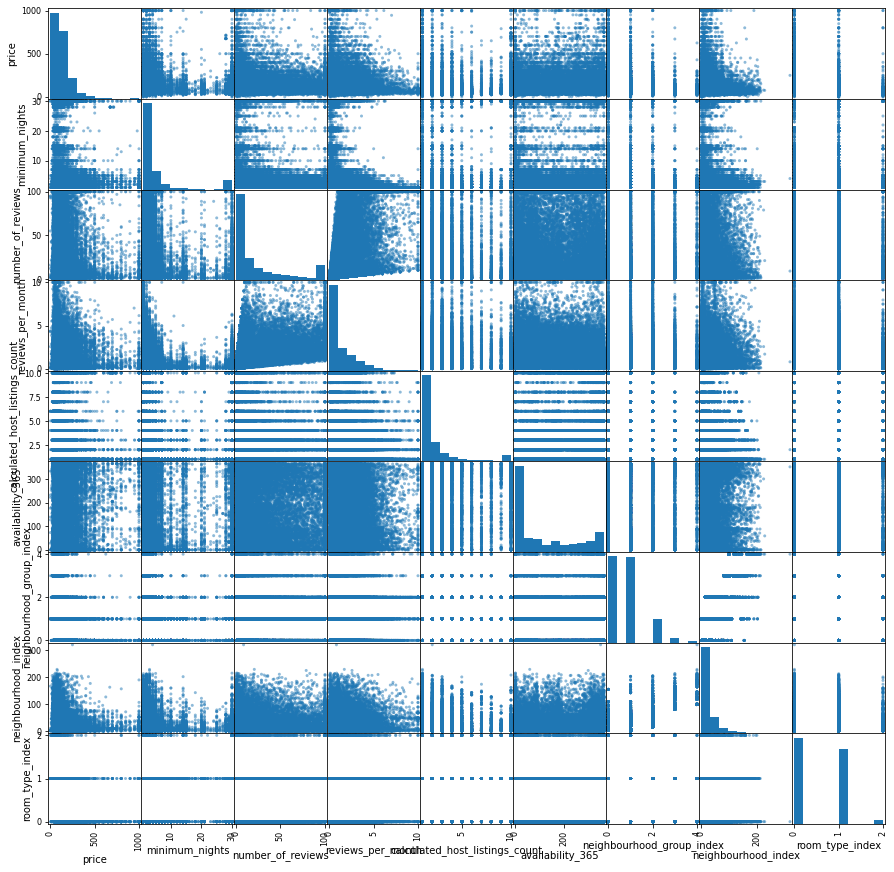

In [87]:
numeric = [col[0] for col in df.dtypes if col[1] in ['int','float','double','decimal(10,0)']]
data_mat = df.select(numeric).toPandas()
data_mat.reviews_per_month = data_mat.reviews_per_month.astype(float)
pd.plotting.scatter_matrix(data_mat, figsize=(15,15));

In [88]:
data_mat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38678 entries, 0 to 38677
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        38678 non-null  object 
 1   longitude                       38678 non-null  object 
 2   price                           38678 non-null  int32  
 3   minimum_nights                  38678 non-null  int32  
 4   number_of_reviews               38678 non-null  int32  
 5   reviews_per_month               38678 non-null  float64
 6   calculated_host_listings_count  38678 non-null  int32  
 7   availability_365                38678 non-null  int32  
 8   neighbourhood_group_index       38678 non-null  float64
 9   neighbourhood_index             38678 non-null  float64
 10  room_type_index                 38678 non-null  float64
dtypes: float64(4), int32(5), object(2)
memory usage: 2.5+ MB
